# Proyecto 1
# Isaac Rodriguez Bribiesca

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

sns.set()
sns.set(style='whitegrid', rc={'axes.titlesize': 16})
sns.set_palette(sns.color_palette("colorblind", 10))

### Read and preprocess data

In [2]:
def sentiment(row):
   if row['Escala'] == 4 or row['Escala'] == 5:
      return 'Positivo'
   if row['Escala'] == 3:
      return 'Neutro'
   else:
      return 'Negativo'

In [3]:
directory = os.getcwd()+"/tripadvisor_data"
files = [f for f in os.listdir(directory) if "csv" in f]

files_dataframes = []

for file in files:
    df = pd.read_csv(directory+"/"+file, sep = ",")
    
    # Create and column to identify business name
    business_name = file.split(".")[0]
    n = df.shape[0]
    business_col = pd.DataFrame({'Negocio': [business_name]*n})
    df = business_col.join(df)
    
    # Create and append column of sentiment according to Score
    # positive: 4,5
    # neutral: 3
    # negative: 1,2
    df['Sentimiento'] = df.apply(lambda row: sentiment(row), axis=1)
    
    # Rename some columns
    df = df.rename(columns={"Nacional ó Internacional": "Tipo_turista",
                           "Número de aportaciones" : "Num_aportaciones",
                           "Título de la opinión" : "Titulo_opinion"})
    
    files_dataframes.append(df)

data = pd.concat(files_dataframes)

In [4]:
data.head()

,Negocio,Género,Edad,Tipo_turista,Calificación,Escala,Num_aportaciones,Titulo_opinion,Opinión,País,Idioma,Dispositivo,Fecha,Sentimiento
0,Pipila,Masculino,38.0,Nacional,Excelente,5,14.0,"""Hermosa vista de la ciudad""","""Hermosa vista de la ciudad y bonito paseo en ...",México,Español,Móvil,7/19/2018,Positivo
1,Pipila,Masculino,37.0,Internacional,Excelente,5,642.0,"""Magical view of the city""","""The view is an easy 5 stars. You will see man...",Canadá,Inglés,Móvil,7/18/2018,Positivo
2,Pipila,Femenino,27.0,Internacional,Excelente,5,16.0,"""¡No te lo pierdas!""","""¡Nos gusta mucho! Aquí verás increíbles vista...",Singapur,Chino,PC,7/14/2018,Positivo
3,Pipila,Femenino,19.0,Nacional,Excelente,5,31.0,"""MONUMENTO Y VISTA PANORÁMICA""","""Una visita a este lugar te hará deleitar la p...",México,Español,PC,7/14/2018,Positivo
4,Pipila,Femenino,20.0,Internacional,Excelente,5,16.0,"""Cannot miss!""","""We loved it! You get an unbelievable view of ...",Estados Unidos,Inglés,Móvil,14/07/2018,Positivo


## 1. Estadísticas básicas

#### a. Promedios de calificación por lugar y desviaciones estándar en los scores

In [51]:
def round_score(val):
    if val > 4.5:
        return "Excelente"
    if val > 3.5:
        return "Bueno"
    if val > 2.5:
        return "Regular"
    if val > 1.5:
        return "Malo"
    else:
        return "Pésimo"

Escala promedio por lugar y desviación estandar

In [58]:
pd.DataFrame({'Escala promedio': data.groupby('Negocio').mean().loc[:,'Escala'],
              'Desviación estandar': data.groupby('Negocio').std().loc[:,'Escala']})

,Escala promedio,Desviación estandar
Negocio,,
Alhondiga,4.454839,0.745711
Basilica,4.500000,0.668750
Callejon_beso,3.995588,0.971247
Casa_diego,4.243553,0.804039
Jardin_union,4.591711,0.607370
Juarez,4.702970,0.518146
Mercado,3.948333,0.950703
Momias,3.675152,1.136495
Pipila,4.377778,0.767950


Calificación promedio por lugar

In [52]:
data.groupby('Negocio').mean().loc[:,'Escala'].transform(round_score)

Negocio
Alhondiga            Bueno
Basilica             Bueno
Callejon_beso        Bueno
Casa_diego           Bueno
Jardin_union     Excelente
Juarez           Excelente
Mercado              Bueno
Momias               Bueno
Pipila               Bueno
Universidad      Excelente
Name: Escala, dtype: object

#### b. Basado en palabras: longitud promedio de opiniones y desviacones estándar

In [67]:
data.groupby('Negocio')['Opinión']\
    .apply(lambda x: np.mean(x.str.len()))\
    .reset_index(name='Longitud promedio opinión')

,Negocio,Longitud promedio opinión
0,Alhondiga,271.788172
1,Basilica,227.189286
2,Callejon_beso,251.116912
3,Casa_diego,277.161891
4,Jardin_union,248.666667
5,Juarez,239.888119
6,Mercado,263.935000
7,Momias,327.655758
8,Pipila,264.432716
9,Universidad,208.566667


#### c. Histogramas de edades de opiniones por lugar

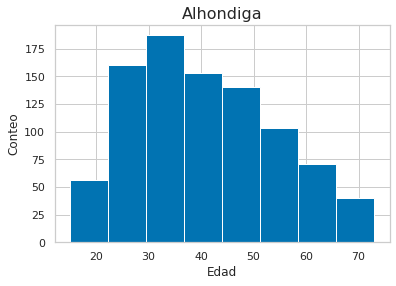

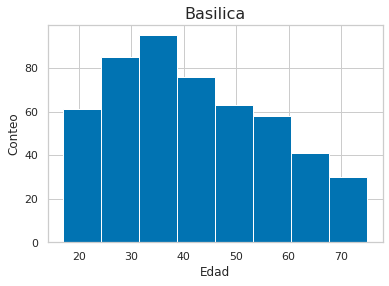

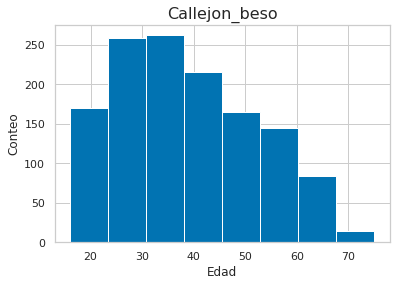

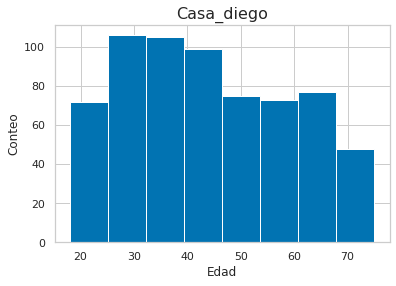

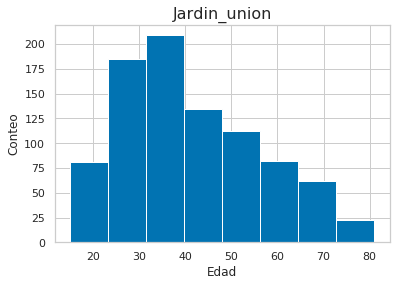

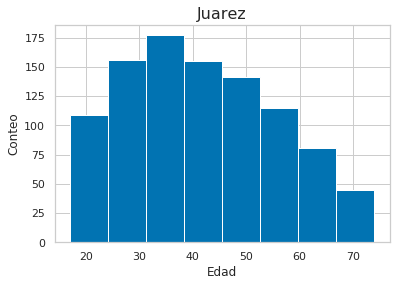

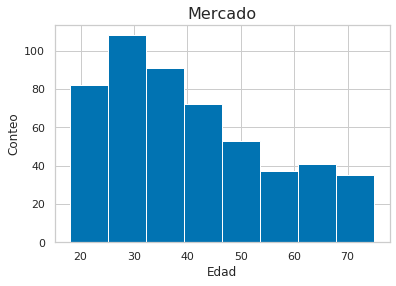

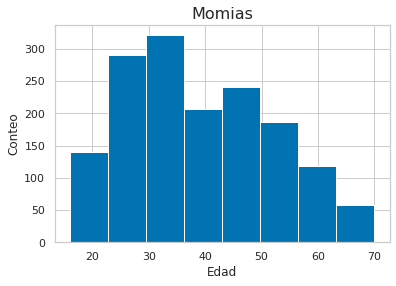

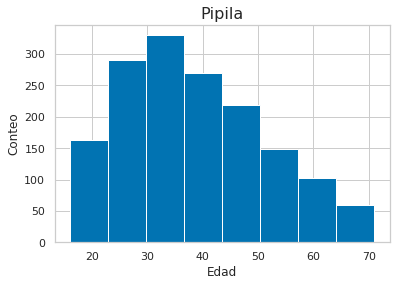

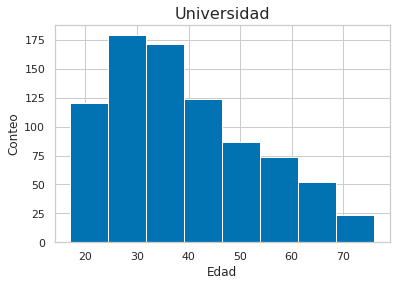

In [29]:
grouped = data.groupby('Negocio')

for group in grouped:
    fig, ax = plt.subplots(1, 1)
    ax.set_title(group[0])
    ax.set_xlabel('Edad')
    ax.set_ylabel('Conteo')
    _ = ax.hist(group[1].Edad, bins=8)
    plt.show()

#### d. Histograma de tipo de visitantes (nacional o internacional) por lugar

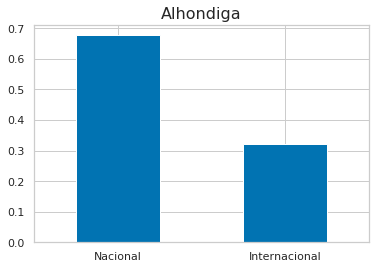

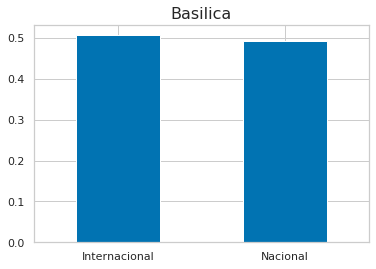

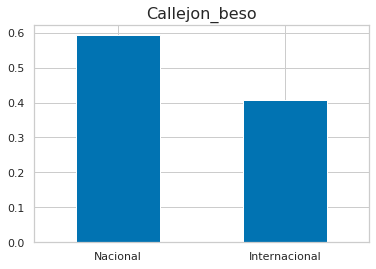

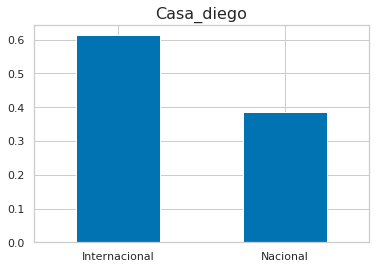

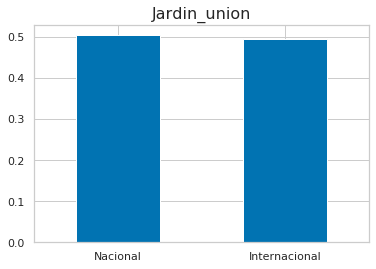

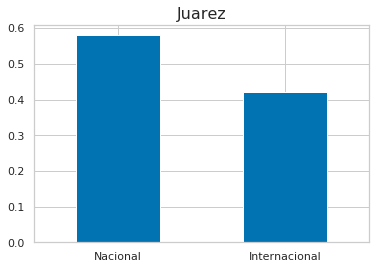

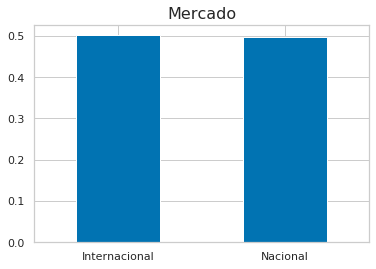

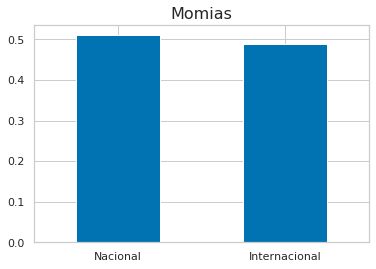

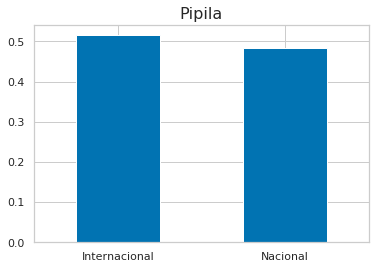

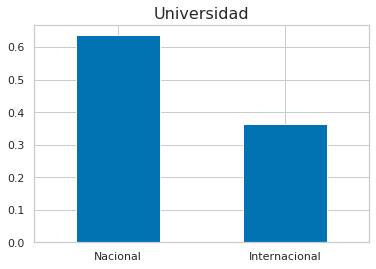

In [27]:
grouped = data.groupby('Negocio')

for group in grouped:
    ax = group[1].loc[:,'Tipo_turista'].value_counts(normalize=True).plot(kind='bar', title = group[0])
    ax.tick_params(labelrotation=0)
    plt.show()

## 2. Feature selection y nube de palabras

In [119]:
opinions = []
locations = []
location_names = []
grouped = data.groupby('Negocio')

for group in grouped:
    group_opinions = [op.strip('\"') for op in group[1].loc[:,'Opinión']]
    group_location = [op.strip('\"') for op in group[1].loc[:,'Negocio']]
    opinions.append(group_opinions)
    locations.append(group_location)
    location_names.append(group[0])

all_opinions = [item for group_opinions in opinions for item in group_opinions]
all_locations = [item for group_location in locations for item in group_location]

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

k = 50
top_words = []

for group_opinions in opinions:

    vectorizer = CountVectorizer()
    tokens_matrix = vectorizer.fit_transform(group_opinions)

    features_chi2 = chi2(tokens_matrix, group_opinions)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]

    group_top_words = [v for v in feature_names if len(v.split(' ')) == 1][:k]
    top_words.append(group_top_words)

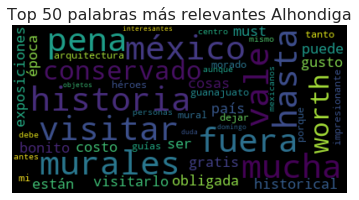

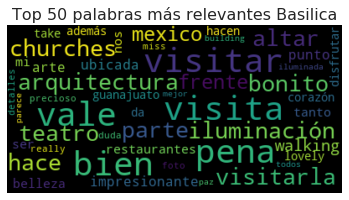

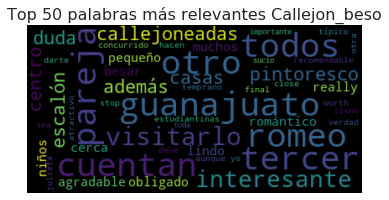

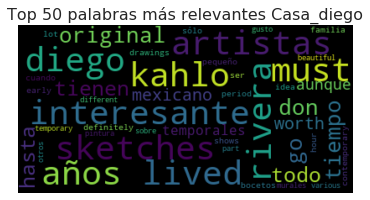

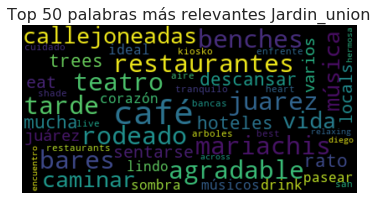

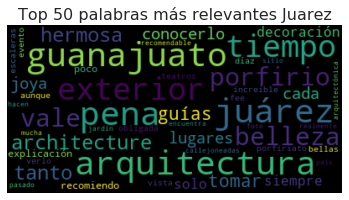

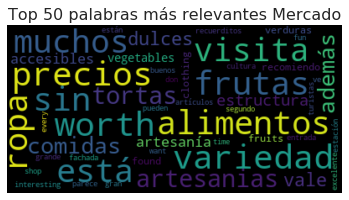

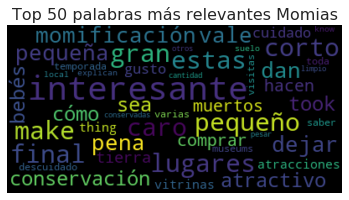

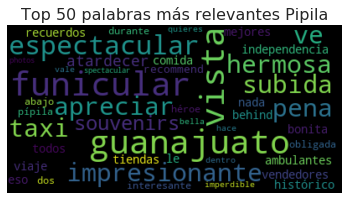

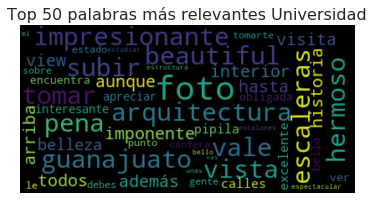

In [122]:
from wordcloud import WordCloud

for group_top_words, name in zip(top_words, location_names):
    text = " ".join(group_top_words)

    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top "+str(k)+" palabras más relevantes " + name)
    plt.show()

## 3. Tópicos LSA